In [39]:
import numpy as np
import keras
import scipy.io as sio
import pandas as pd
import tensorflow as tf

from sklearn import model_selection
from sklearn import preprocessing

import matplotlib.pyplot as plt 
from keras import layers
from keras.models import Sequential

#from livelossplot.keras import PlotLossesCallback
from IPython.display import clear_output
from keras.utils.vis_utils import plot_model
#from sklearn import preprocessing
#import math

from skimage import feature
from skimage.filters import gaussian

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
keras.backend.clear_session()

In [4]:
filename = '../data/raw/MarmousiModel2.mat'
marmousi_cube = sio.loadmat(filename)

### Carregar dados e cubos de Sísmica e Impedância

In [5]:
VP = marmousi_cube['Vp']
#VS = marmousi_cube['Vs']
#IS = marmousi_cube['IS']
#WAVELET = marmousi_cube['wavelet']
pimpedance = marmousi_cube['IP']
seismic = marmousi_cube['seismic']


### Parameters 

In [6]:
n_traces = pimpedance.shape[1]

train_wells_loc = np.arange(0,n_traces,135)
all_wells_loc = np.arange(n_traces)

wells_loc = np.array(list(set(all_wells_loc) - set(train_wells_loc)))
valid_wells_loc, unlabed_wells_loc = model_selection.train_test_split(wells_loc,
                                                                      test_size=0.9,
                                                                      train_size=0.1,
                                                                      shuffle=True)

### Normalizar Sismica

In [7]:
seismic_norm = seismic.flatten()
ymin = 0
ymax = 1
seismic_norm = (ymax-ymin)*(seismic_norm-np.min(seismic_norm))/(np.max(seismic_norm)-np.min(seismic_norm)) + ymin
seismic_norm = seismic_norm.reshape(seismic.shape)
#seismic_norm = seismic

In [8]:
pimpedance_norm = pimpedance.flatten()
ymin = 0
ymax = 1
pimpedance_norm = (ymax-ymin)*(pimpedance_norm-np.min(pimpedance_norm))/(np.max(pimpedance_norm)-np.min(pimpedance_norm)) + ymin
pimpedance = pimpedance_norm.reshape(pimpedance.shape)
#seismic_norm = seismic

### Visualizar estatísticas

In [9]:
'''data_info = pd.DataFrame(zip(seismic_norm.flatten(),
                             pimpedance.flatten()),
                         columns=['Seismic CL Stats','PImp CL Stats'])
data_info.describe()'''

"data_info = pd.DataFrame(zip(seismic_norm.flatten(),\n                             pimpedance.flatten()),\n                         columns=['Seismic CL Stats','PImp CL Stats'])\ndata_info.describe()"

### Preparar os Dados

In [10]:
X_train = np.transpose(seismic_norm[:,train_wells_loc[0:50]])
Y_train = np.transpose(pimpedance[:-1,train_wells_loc[0:50]])
X_train = np.expand_dims(X_train,axis=2)
Y_train = np.expand_dims(Y_train,axis=2)


X_valid = np.transpose(seismic_norm[:,valid_wells_loc])
Y_valid = np.transpose(pimpedance[:-1,valid_wells_loc])
X_valid = np.expand_dims(X_valid,axis=2)
Y_valid = np.expand_dims(Y_valid,axis=2)

X_test = np.transpose(seismic_norm)
Y_test = np.transpose(pimpedance[:-1,:])
X_test = np.expand_dims(X_test,axis=2)
Y_test = np.expand_dims(Y_test,axis=2)


In [11]:
print('     IP (Y_train) shape: ',Y_train.shape)
print('seismic (X_train) shape: ',X_train.shape)

print('     IP (Y_valid) shape: ',Y_valid.shape)
print('seismic (X_valid) shape: ',X_valid.shape)

print('     IP (Y_test) shape: ',Y_test.shape)
print('seismic (X_test) shape: ',X_test.shape)

     IP (Y_train) shape:  (50, 2800, 1)
seismic (X_train) shape:  (50, 2800, 1)
     IP (Y_valid) shape:  (1350, 2800, 1)
seismic (X_valid) shape:  (1350, 2800, 1)
     IP (Y_test) shape:  (13601, 2800, 1)
seismic (X_test) shape:  (13601, 2800, 1)


### Visualizar Dados

Text(0.5, 1.0, 'Output P-Impedance Test - Ground True')

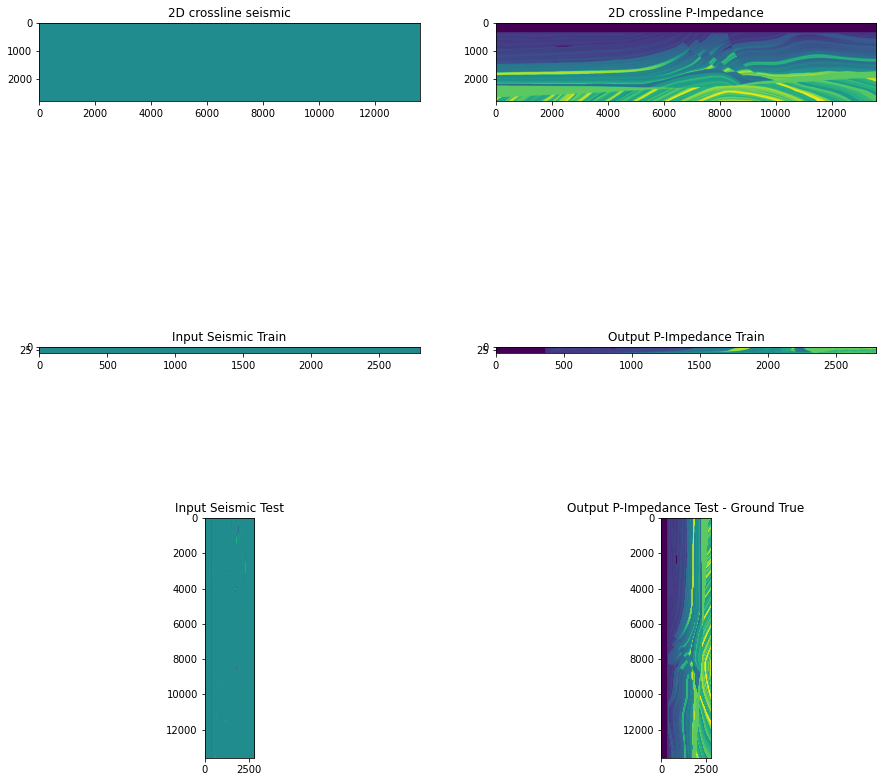

In [12]:
fig1, axes1 = plt.subplots(nrows=3, ncols=2, figsize=(15,15))

axes1[0,0].imshow(seismic)
axes1[0,0].set_title("2D crossline seismic")

axes1[0,1].imshow(pimpedance)
axes1[0,1].set_title("2D crossline P-Impedance")

axes1[1,0].imshow(X_train[:,:,0])
axes1[1,0].set_title("Input Seismic Train")

axes1[1,1].imshow(Y_train[:,:,0])
axes1[1,1].set_title("Output P-Impedance Train")

axes1[2,0].imshow(X_test[:,:,0])
axes1[2,0].set_title("Input Seismic Test")
axes1[2,1].imshow(Y_test[:,:,0])
axes1[2,1].set_title("Output P-Impedance Test - Ground True")

## Create and Train LSTM

### Create Net

In [13]:
num_features = 1
num_hidden_units1 = 300
num_hidden_units2 = 300
num_responses = 1
max_epochs = 1000
mini_batch_size = 10


In [14]:
callback =  tf.keras.callbacks.EarlyStopping(monitor='loss', 
            mode='min',
            restore_best_weights=True, 
            verbose=1, 
            patience=300)

In [15]:
model = Sequential([
    layers.Bidirectional(
        layers.LSTM(units=num_hidden_units1, return_sequences=True,), input_shape=(2800,1)),
    layers.BatchNormalization(epsilon=1e-4),
    layers.ReLU(),
    layers.Dense(150),
    layers.Dense(50),
    layers.Bidirectional(
        layers.LSTM(units=num_hidden_units2, return_sequences=True)
    ),
    layers.Dense(num_responses)
])

'''model = Sequential([
    layers.LSTM(units=numHiddenUnits1,input_shape=(700,1),return_sequences=True),
    layers.Dropout(0.5),
    layers.LSTM(units=numHiddenUnits2,return_sequences=True),
    layers.Dropout(0.2),
    layers.Dense(10),
    layers.Dense(numResponses)
])'''
' '
#model.build()
#model.summary()

' '

## Treinando a Rede

In [16]:
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt,loss='mean_squared_error',metrics='mean_squared_error')

Epoch 1/1000
5/5 [==============================] - 36s 7s/step - loss: 5.7408 - mean_squared_error: 5.7408 - val_loss: 0.9393 - val_mean_squared_error: 0.9393
Epoch 2/1000
5/5 [==============================] - 25s 6s/step - loss: 0.4548 - mean_squared_error: 0.4548 - val_loss: 0.0859 - val_mean_squared_error: 0.0859
Epoch 3/1000
5/5 [==============================] - 26s 6s/step - loss: 0.1665 - mean_squared_error: 0.1665 - val_loss: 0.8220 - val_mean_squared_error: 0.8220
Epoch 4/1000
5/5 [==============================] - 26s 6s/step - loss: 0.1999 - mean_squared_error: 0.1999 - val_loss: 0.8318 - val_mean_squared_error: 0.8318
Epoch 5/1000
5/5 [==============================] - 26s 6s/step - loss: 0.6543 - mean_squared_error: 0.6543 - val_loss: 1.1887 - val_mean_squared_error: 1.1887
Epoch 6/1000
5/5 [==============================] - 26s 6s/step - loss: 0.1858 - mean_squared_error: 0.1858 - val_loss: 0.2637 - val_mean_squared_error: 0.2637
Epoch 7/1000
5/5 [======================

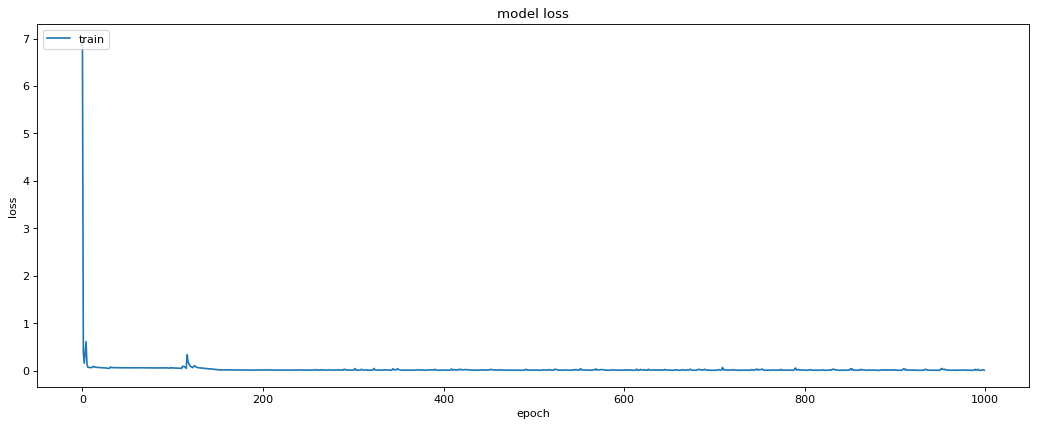

In [17]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_valid, Y_valid),
    epochs=max_epochs,
    batch_size=mini_batch_size,
    validation_freq=1,
    shuffle=True,
    verbose=1,
    callbacks = callback
)

plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w')
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Testando a Rede

In [18]:
X_predict = np.zeros(Y_test.shape[0:2]) 

X_predict.shape

(13601, 2800)

In [19]:
for i in range(round((X_predict.shape[0])/50)):
    start_,stop_ = (i*50),(i+1)*50
    if start_ >= X_predict.shape[0]:
        start_ = X_predict.shape[0]
    if stop_ >= X_predict.shape[0]:
        stop_ = X_predict.shape[0]    
    #print(start_,stop_ )
    X_predict[start_:stop_,:] =model(X_test[start_:stop_,:])[:,:,0]
X_predict = np.transpose(X_predict)

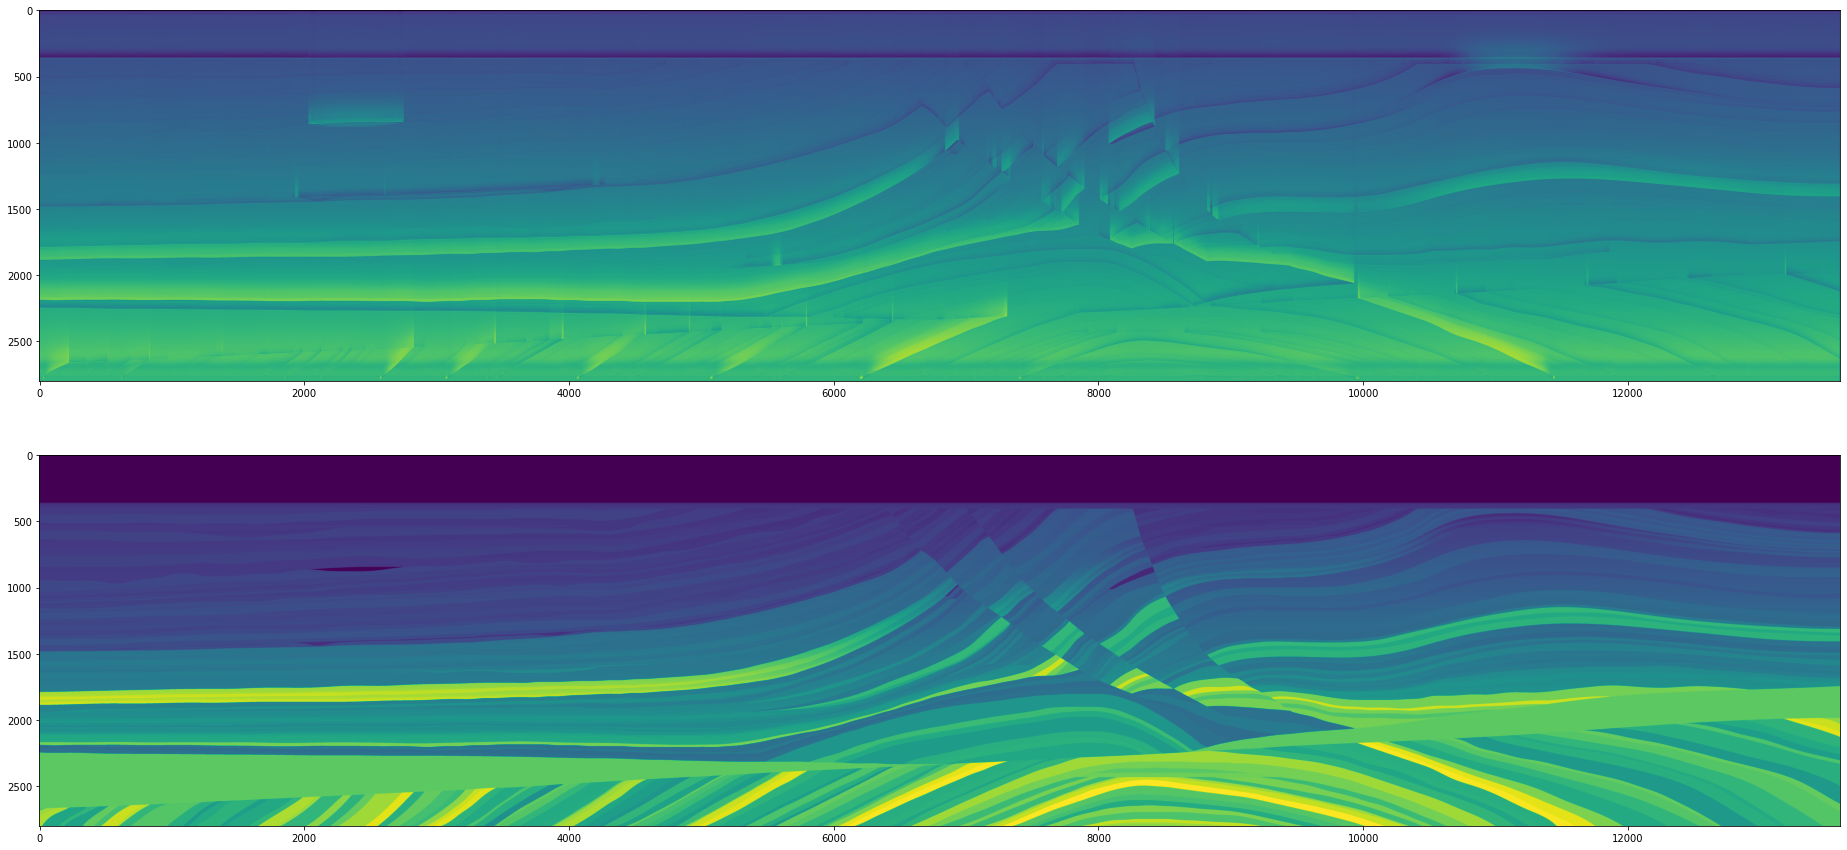

In [20]:
fig1, axes1 = plt.subplots(nrows=2, ncols=1, figsize=(50,15))
axes1[0].imshow(X_predict)
axes1[1].imshow(np.transpose(Y_test[:,:,0]))

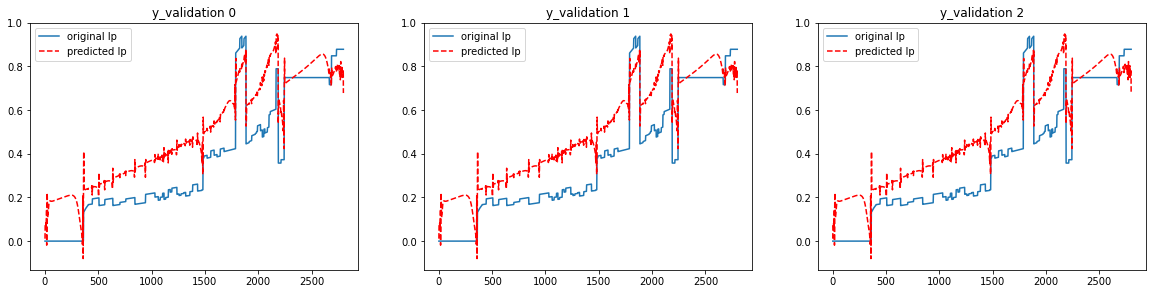

In [42]:
# trace_id = np.random.randint(X_predict.shape[1])
# plt.plot(X_predict[:,trace_id])
# plt.plot(Y_test[trace_id,:,0])
# plt.legend(('target','predicted'))

test_imp = Y_test[:,:,0].T

n = 3
plt.figure(figsize=(20, 10))
for i in range(1, n + 1):
    ax = plt.subplot(2, n, i)
    ax.set_title("y_validation {0}".format(i-1))
    plt.plot(test_imp[:,i-1])
    plt.plot(X_predict[:, i-1], '--r')
    plt.legend(['original Ip', 'predicted Ip'])
plt.show()

SSIM:  0.78951854
SSIM Multiscale:  0.84207714


Text(0.5, 1.0, 'Target')

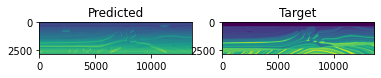

In [35]:
original_shape = np.expand_dims(X_predict, axis=2)

predict_image = np.expand_dims(X_predict, axis=2)
predict_image = (predict_image-np.min(predict_image))/(np.max(predict_image)-np.min(predict_image))
predict_image = predict_image.reshape(original_shape.shape)
predict_image = (predict_image).astype('float32')

target_image = np.expand_dims(test_imp, axis=2)
target_image = (target_image-np.min(target_image))/(np.max(target_image)-np.min(target_image))
target_image = target_image.reshape(original_shape.shape)
target_image = target_image.astype('float32')

SSIM = tf.image.ssim(target_image, predict_image, max_val=1).numpy()
MSSIM = tf.image.ssim_multiscale(target_image, predict_image, max_val=1, power_factors=(0.0448, 0.2856, 0.3001, 0.2363)).numpy()
print('SSIM: ', SSIM)
print('SSIM Multiscale: ', MSSIM)

fig1, axes1 = plt.subplots(nrows=1, ncols=2)
axes1[0].imshow(predict_image[:,:,0])
axes1[0].set_title("Predicted")
axes1[1].imshow(target_image[:,:,0])
axes1[1].set_title("Target")

In [36]:
mse_res = tf.keras.metrics.mean_squared_error(target_image.flatten(), predict_image.flatten()).numpy()
mae_res = tf.keras.metrics.mean_absolute_error(target_image.flatten(), predict_image.flatten()).numpy()

m = tf.keras.metrics.RootMeanSquaredError()
m.update_state(target_image.flatten(), predict_image.flatten())

print(f"MSE: ", mse_res)
print("MAE: ", mae_res)
print("RMSE: ", m.result().numpy())

MSE:  0.018266555
MAE:  0.113886386
RMSE:  0.13515382


In [37]:
def soft_F_measure(target_data,
                   predicted_data,
                   canny_sigma=3,
                   gaussian_sigma=1,
                   beta_F1=1,
                   plot_data=True):
    e = feature.canny(target_data, sigma=canny_sigma)
    e_ = feature.canny(predicted_data, sigma=canny_sigma)

    e_ = gaussian(e_,sigma=gaussian_sigma,multichannel=None, preserve_range=True)
    #e_ = e_/np.max(e_.flatten())-np.min(e_.flatten())

    TP = np.minimum(e,e_)
    TN = np.minimum(1-e,1-e_)
    FP = np.maximum(e_ - e , np.zeros(e.shape))
    FN = np.maximum(e - e_ , np.zeros(e.shape))
    sTP = np.sum(TP.flatten())
    sTN = np.sum(TN.flatten())
    sFP = np.sum(FP.flatten())
    sFN = np.sum(FN.flatten())
    
    soft_precision = sTP/(sTP+sFP)
    soft_recall = sTP/(sTP+sFN)
    
    soft_FM = (1+beta_F1**2)*(soft_precision*soft_recall)/(soft_precision*(beta_F1**2)+soft_recall)
    if plot_data:
    
        fig, ax = plt.subplots(nrows=2, ncols=4,figsize=(16, 8))
        ax[0,0].imshow(target_data)
        ax[0,0].set_title('ground truth')

        ax[1,0].imshow(e, cmap='gray')
        ax[1,0].set_title('ground truth, canny, sigma:{}'.format(canny_sigma))

        ax[0,1].imshow(predicted_data)
        ax[0,1].set_title('predicted')

        ax[1,1].imshow(e_, cmap='gray')
        ax[1,1].set_title('predicted, canny, sigma:{}'.format(canny_sigma))
        
        ax[0,2].imshow(TP)
        ax[0,2].set_title('True Positive')

        ax[1,2].imshow(TN)
        ax[1,2].set_title('True Negative')

        ax[0,3].imshow(FP)
        ax[0,3].set_title('False Positive'.format(canny_sigma))

        ax[1,3].imshow(FN)
        ax[1,3].set_title('False Negative'.format(canny_sigma))

        fig.tight_layout()
        plt.show()
        
    return soft_FM

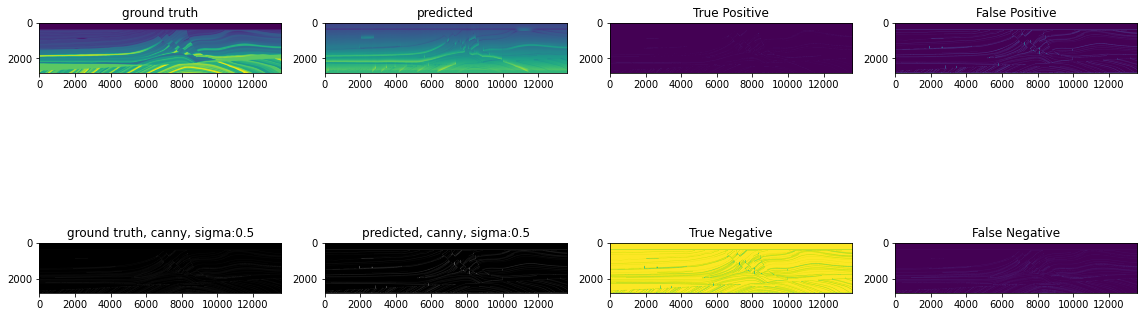

0.1436137086375332


In [41]:
Fb = soft_F_measure(target_data=target_image[:,:,0],
                    predicted_data=predict_image[:,:,0],                 
                    canny_sigma=0.5,
                    gaussian_sigma=0.5,
                    beta_F1=1,
                    plot_data=True)

print(Fb)